In [1]:
import nest_asyncio
nest_asyncio.apply()

In [2]:
import nest_asyncio
nest_asyncio.apply()
import collections
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from tensorflow import reshape, nest, config
from tensorflow.keras.datasets import mnist
import pandas as pd
from random import sample
from matplotlib import pyplot as plt
from sklearn import preprocessing
from uuid import uuid4
import pickle
np.random.seed(0)

# Set up data

In [3]:
datapath = '/ssd003/projects/pets/application_train.csv'
raw_train = pd.read_csv(datapath)
raw_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# Preprocessing Function

In [4]:
def data_preprocessing(df):
    target = 'TARGET'
    id_col = 'SK_ID_CURR'

    #Delete target column as it is not useful for prediction
    del df[id_col]

    #Distribution of target variable
    df[target].value_counts()

    #Store target variable to be used later
    target_val = df[target]

    #Delete target column from features
    target_col = df.pop(target)

    # Write UID
    uid_col = pd.Series([uuid4() for _ in range(len(df))])

    # Get all continuous variabels 
    cont_vars = []
    for col in df.columns:
        if df[col].dtype == 'int64' or df[col].dtype == 'float64':
            cont_vars.append(col)

    #Store number of continous variable. This will be equivalent to number of neurons in input layer
    cont_train = df.loc[:, cont_vars]
    curr_dim = cont_train.shape[1]
    
    #Fill NAs with mean value of column. Lot of scope of improvement here :)
    cont_train = cont_train.fillna(cont_train.mean())

    #Normalize features using standard scaler. We will use same standard scaler object to normalize test data
    std_scale = preprocessing.StandardScaler().fit(cont_train[cont_vars])
    cont_train[cont_vars] = std_scale.transform(cont_train[cont_vars])
    
    # Extract home credit subdataset
    home_credit_cols = [col for col in cont_train.columns if "credit_bureau" not in str.lower(col)]
    home_credit_df = cont_train[home_credit_cols].copy()
    home_credit_df["target"] = target_col
    return home_credit_df

# Set up partitions

In [5]:
positive_class = raw_train[raw_train.TARGET == 1]
negative_class = raw_train[raw_train.TARGET == 0]
(len(positive_class), len(negative_class))

(24825, 282686)

In [6]:
len(positive_class) / 4

6206.25

In [7]:
n_positive = 6000
n_negative = 14000
(n_positive, n_negative, n_positive + n_negative, n_positive/(n_positive + n_negative))

(6000, 14000, 20000, 0.3)

In [8]:
pos_sizes = np.cumsum([n_positive, n_positive, n_positive, n_positive])
pos_dfs = np.array_split(positive_class.sample(frac=1), pos_sizes)
print([len(d) for d in pos_dfs])

[6000, 6000, 6000, 6000, 825]


In [9]:
neg_sizes = np.cumsum([n_negative, n_negative, n_negative, n_negative])
neg_dfs = np.array_split(negative_class.sample(frac=1), neg_sizes)
print([len(d) for d in neg_dfs])

[14000, 14000, 14000, 14000, 226686]


In [10]:
#sizes = np.cumsum([10000, 10000, 10000, 10000])
#dfs = np.array_split(raw_train.sample(frac=1), sizes)
#print([len(d) for d in dfs])

In [11]:
data1 = data_preprocessing(pd.concat([pos_dfs[0], neg_dfs[0]]).sample(frac=1))
data1['hospital_id'] = 1

data2 = data_preprocessing(pd.concat([pos_dfs[1], neg_dfs[1]]).sample(frac=1))
data2['hospital_id'] = 2

data3 = data_preprocessing(pd.concat([pos_dfs[2], neg_dfs[2]]).sample(frac=1))
data3['hospital_id'] = 3

data4 = data_preprocessing(pd.concat([pos_dfs[3], neg_dfs[3]]).sample(frac=1))
data4['hospital_id'] = 4

In [12]:
print(len(data1)) 
print(data1.target.value_counts(normalize=True))
print(len(data2)) 
print(data2.target.value_counts(normalize=True))
print(len(data3)) 
print(data3.target.value_counts(normalize=True))
print(len(data4)) 
print(data4.target.value_counts(normalize=True))

20000
0    0.7
1    0.3
Name: target, dtype: float64
20000
0    0.7
1    0.3
Name: target, dtype: float64
20000
0    0.7
1    0.3
Name: target, dtype: float64
20000
0    0.7
1    0.3
Name: target, dtype: float64


# Combine and format DataFrame

In [14]:
data = pd.concat([data1, data2, data3, data4])

In [15]:
pickle.dump(data, open("data_fed.pkl.gz",'wb'))

In [16]:
df = data
new = df.copy()
del new['target']
data['features']= new.values.tolist()

#data['hospital_id'] = np.random.randint(1,5, size=len(data))
data = data[['target', 'hospital_id', 'features']]
data.index = range(len(data))

In [17]:
data.head()

,target,hospital_id,features
0,0,1,"[-0.5839614690282836, 0.5990085327679894, -0.2..."
1,0,1,"[-0.5839614690282836, 0.8281093138655685, -0.8..."
2,0,1,"[2.1640925028695217, -0.7755961538174854, -0.4..."
3,1,1,"[0.790065516920619, 1.0572100949631478, 0.0289..."
4,1,1,"[-0.5839614690282836, -0.088293810524748, 1.73..."


In [18]:
data.shape

(80000, 3)

In [19]:
data.hospital_id.value_counts()

4    20000
3    20000
2    20000
1    20000
Name: hospital_id, dtype: int64

# Relabel the clients to construct an 'unfederated' set

In [28]:
data_unfed = data.copy()

In [29]:
data_unfed.hospital_id = data_unfed.hospital_id.map({1:1, 2:1, 3:1, 4:4})

In [30]:
data_unfed.hospital_id.value_counts()

1    60000
4    20000
Name: hospital_id, dtype: int64

In [32]:
data_unfed[data_unfed.hospital_id==1].target.value_counts(normalize=True)

0    0.7
1    0.3
Name: target, dtype: float64

In [33]:
data_unfed[data_unfed.hospital_id==4].target.value_counts(normalize=True)

0    0.7
1    0.3
Name: target, dtype: float64

# Number of features

In [34]:
n_features = len(data['features'][0])
n_features

99

# Set up the sets of ids

In [35]:
client_id_colname = 'hospital_id' #column that represents client ID 
number_of_training_clients = 3

train_client_ids = [1,2,3]
test_client_ids = [4]

# Create some TF datasets

In [59]:
SHUFFLE_BUFFER = 1000
NUM_EPOCHS = 10

def create_tf_dataset_for_client_fn(client_id):
    client_data = data[data[client_id_colname] == client_id]
    dataset = tf.data.Dataset.from_tensor_slices(client_data.to_dict('list'))
    dataset = dataset.shuffle(SHUFFLE_BUFFER).batch(1).repeat(NUM_EPOCHS)
    return dataset

def create_tf_dataset_for_client_fn_unfed(client_id):
    client_data = data_unfed[data_unfed[client_id_colname] == client_id]
    dataset = tf.data.Dataset.from_tensor_slices(client_data.to_dict('list'))
    dataset = dataset.shuffle(SHUFFLE_BUFFER).batch(1).repeat(NUM_EPOCHS)
    return dataset

In [58]:
train_data = tff.simulation.datasets.ClientData.from_clients_and_tf_fn(
    client_ids=train_client_ids, 
    serializable_dataset_fn=create_tf_dataset_for_client_fn)

test_data = tff.simulation.datasets.ClientData.from_clients_and_tf_fn(
    client_ids=test_client_ids,
    serializable_dataset_fn=create_tf_dataset_for_client_fn)

In [60]:
train_data_unfed = tff.simulation.datasets.ClientData.from_clients_and_tf_fn(
    client_ids=[1], 
    serializable_dataset_fn=create_tf_dataset_for_client_fn_unfed)

# Batch preprocessing function

In [38]:
NUM_EPOCHS = 10
BATCH_SIZE = 5000
PREFETCH_BUFFER = 2500
def preprocess(dataset):
    def batch_format_fn(element):    
        return collections.OrderedDict(x=tf.reshape(element['features'], [-1,n_features]),
                                       y=tf.reshape(element['target'], [-1,1]))

    return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

In [39]:
example_dataset = train_data.create_tf_dataset_for_client(
        train_data.client_ids[2]
    )
print(example_dataset)
example_element = iter(example_dataset).next()
print(example_element)

<RepeatDataset element_spec={'target': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'hospital_id': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'features': TensorSpec(shape=(None, 99), dtype=tf.float32, name=None)}>
{'target': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, 'hospital_id': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([3], dtype=int32)>, 'features': <tf.Tensor: shape=(1, 99), dtype=float32, numpy=
array([[-0.5953342 ,  0.09444522, -0.93573403, -0.0204729 , -0.8494229 ,
         0.42770228,  1.4946942 , -0.43475264,  1.1287721 ,  0.97185266,
         0.        ,  0.        ,  0.4448502 ,  1.9413184 ,  0.04532341,
         1.6361988 ,  4.059867  , -1.266296  , -0.14118426, -0.10683697,
         1.5219933 , -0.12423609, -0.23277697, -0.2092531 , -0.31072712,
        -0.57981366, -0.49288014, -2.2471657 , -0.76547545, -1.2095678 ,
         2.6186838 ,  2.813472  ,  0.2750857 ,  1.6477365 ,  0.59551644,
         1.4281416 ,  4.769797

In [40]:
preprocessed_example_dataset = preprocess(example_dataset)
sample_batch = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(preprocessed_example_dataset)))

sample_batch

OrderedDict([('x',
              array([[-0.5953342 , -0.57504314, -0.5323083 , ..., -0.02121798,
                      -0.02345853,  3.        ],
                     [-0.5953342 , -0.37419662, -0.11737919, ..., -0.02121798,
                      -0.02345853,  3.        ],
                     [-0.5953342 , -0.725678  , -0.11737919, ..., -0.02121798,
                      -0.02345853,  3.        ],
                     ...,
                     [-0.5953342 , -0.24029896, -0.6772649 , ..., -0.02121798,
                      -0.02345853,  3.        ],
                     [ 0.7705811 , -0.24029896,  0.4223122 , ..., -0.02121798,
                      -0.02345853,  3.        ],
                     [-0.5953342 ,  0.5965615 ,  1.1806374 , ..., -0.02121798,
                      -0.02345853,  3.        ]], dtype=float32)),
             ('y',
              array([[0],
                     [0],
                     [1],
                     ...,
                     [1],
                    

In [44]:
sample_batch['x'].shape

(5000, 99)

# Federated data preprocessing

In [45]:
def make_federated_data(client_data, client_ids):
    return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
    ]

# Keras model

In [90]:
def create_keras_model():
    return tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(n_features,)), # n_features
      tf.keras.layers.Dense(150, activation = 'swish'),
        tf.keras.layers.Dense(50, activation = 'swish'),
        tf.keras.layers.Dense(1, activation = 'sigmoid'),
      ])

In [91]:
import tensorflow_addons as tfa

def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
    keras_model = create_keras_model()
    return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_example_dataset.element_spec,
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(name='Precision'),
               tf.keras.metrics.Recall(name='Recall'), tf.keras.metrics.AUC(name='AUC')])

# Training Loop

In [92]:
evaluation = tff.learning.build_federated_evaluation(model_fn)

In [93]:
def training_loop(federated_train_data, federated_test_data, iterative_process, NUM_ROUNDS):
    
    list_metrics = []
    list_val_metrics = []

    state = iterative_process.initialize()

    for round_num in range(1, NUM_ROUNDS+1):
        state, metrics = iterative_process.next(state, federated_train_data)
        val_metrics = evaluation(state.model, federated_test_data)

        list_metrics.append(metrics)
        list_val_metrics.append(val_metrics)
        
        print()
        print(pd.concat([
            pd.DataFrame([list_val_metrics[i]['eval'] for i in range(len(list_val_metrics))]),
            pd.DataFrame([list_metrics[i]['train'] for i in range(len(list_metrics))]),
        ], axis=1))

    return {
        'state':state,
        'training':list_metrics,
        'eval':list_val_metrics,
    }

# Unfederated

In [94]:
%%time
results_unfed = []

train_data = tff.simulation.datasets.ClientData.from_clients_and_tf_fn(
    client_ids=[1], 
    serializable_dataset_fn=create_tf_dataset_for_client_fn_unfed) # different serialization fn

test_data = tff.simulation.datasets.ClientData.from_clients_and_tf_fn(
    client_ids=[4],
    serializable_dataset_fn=create_tf_dataset_for_client_fn)

unfederated_train_data = make_federated_data(train_data, [1])
unfederated_test_data = make_federated_data(test_data, [4])

for i in range(10):
    print()
    print(i)
    
    iterative_process = tff.learning.build_federated_averaging_process(
        model_fn,
        client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.1),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.1))

    result = training_loop(unfederated_train_data, unfederated_test_data, iterative_process, 20)
    results_unfed.append(result)


0

   binary_accuracy  Precision    Recall      AUC      loss  binary_accuracy  \
0           0.5616   0.357935  0.581167  0.59173  0.684603         0.731638   

   Precision    Recall       AUC      loss  
0   0.610673  0.290953  0.729205  0.539324  

   binary_accuracy  Precision    Recall      AUC      loss  binary_accuracy  \
0          0.56160   0.357935  0.581167  0.59173  0.684603         0.731638   
1          0.62205   0.399354  0.515500  0.62993  0.659433         0.732799   

   Precision    Recall       AUC      loss  
0   0.610673  0.290953  0.729205  0.539324  
1   0.613178  0.296168  0.731866  0.537437  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.56160   0.357935  0.581167  0.591730  0.684603         0.731638   
1          0.62205   0.399354  0.515500  0.629930  0.659433         0.732799   
2          0.66320   0.442518  0.472167  0.658247  0.638612         0.733746   

   Precision    Recall       AUC      loss  
0   0.


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.56160   0.357935  0.581167  0.591730  0.684603         0.731638   
1           0.62205   0.399354  0.515500  0.629930  0.659433         0.732799   
2           0.66320   0.442518  0.472167  0.658247  0.638612         0.733746   
3           0.68500   0.472757  0.433833  0.678844  0.621285         0.734531   
4           0.70155   0.503164  0.410833  0.693583  0.606819         0.735272   
5           0.71035   0.523036  0.391667  0.704281  0.594744         0.735849   
6           0.71660   0.539004  0.382333  0.711861  0.584652         0.736366   
7           0.71960   0.547852  0.374000  0.717417  0.576241         0.736825   
8           0.72280   0.557114  0.370667  0.721462  0.569249         0.737262   
9           0.72440   0.562789  0.364500  0.724533  0.563368         0.737650   
10          0.72575   0.567391  0.361333  0.726902  0.558518         0.738022   
11          0.72585   0.568


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.56160   0.357935  0.581167  0.591730  0.684603         0.731638   
1           0.62205   0.399354  0.515500  0.629930  0.659433         0.732799   
2           0.66320   0.442518  0.472167  0.658247  0.638612         0.733746   
3           0.68500   0.472757  0.433833  0.678844  0.621285         0.734531   
4           0.70155   0.503164  0.410833  0.693583  0.606819         0.735272   
5           0.71035   0.523036  0.391667  0.704281  0.594744         0.735849   
6           0.71660   0.539004  0.382333  0.711861  0.584652         0.736366   
7           0.71960   0.547852  0.374000  0.717417  0.576241         0.736825   
8           0.72280   0.557114  0.370667  0.721462  0.569249         0.737262   
9           0.72440   0.562789  0.364500  0.724533  0.563368         0.737650   
10          0.72575   0.567391  0.361333  0.726902  0.558518         0.738022   
11          0.72585   0.568


   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.6397   0.352133  0.239333  0.555598  0.655455         0.729988   

   Precision    Recall      AUC      loss  
0   0.604025  0.290205  0.72696  0.540926  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.6397   0.352133  0.239333  0.555598  0.655455         0.729988   
1           0.6725   0.411632  0.213500  0.607184  0.633322         0.731408   

   Precision    Recall      AUC      loss  
0   0.604025  0.290205  0.72696  0.540926  
1   0.607324  0.296214  0.72986  0.538968  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.6397   0.352133  0.239333  0.555598  0.655455         0.729988   
1           0.6725   0.411632  0.213500  0.607184  0.633322         0.731408   
2           0.6941   0.477255  0.206333  0.645215  0.615514         0.732491   

   Precision    Recall       AUC      loss  
0   0.604


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.63970   0.352133  0.239333  0.555598  0.655455         0.729988   
1           0.67250   0.411632  0.213500  0.607184  0.633322         0.731408   
2           0.69410   0.477255  0.206333  0.645215  0.615514         0.732491   
3           0.70590   0.524502  0.210500  0.671759  0.601009         0.733346   
4           0.71305   0.555793  0.216667  0.690032  0.589145         0.734092   
5           0.71770   0.574873  0.226500  0.702215  0.579343         0.734745   
6           0.72175   0.589691  0.238333  0.710883  0.571266         0.735339   
7           0.72420   0.596032  0.250333  0.717100  0.564625         0.735852   
8           0.72650   0.601845  0.261000  0.721593  0.559124         0.736323   
9           0.72735   0.602243  0.268500  0.724823  0.554615         0.736788   
10          0.72890   0.605015  0.277500  0.727405  0.550895         0.737253   
11          0.72930   0.604


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.63970   0.352133  0.239333  0.555598  0.655455         0.729988   
1           0.67250   0.411632  0.213500  0.607184  0.633322         0.731408   
2           0.69410   0.477255  0.206333  0.645215  0.615514         0.732491   
3           0.70590   0.524502  0.210500  0.671759  0.601009         0.733346   
4           0.71305   0.555793  0.216667  0.690032  0.589145         0.734092   
5           0.71770   0.574873  0.226500  0.702215  0.579343         0.734745   
6           0.72175   0.589691  0.238333  0.710883  0.571266         0.735339   
7           0.72420   0.596032  0.250333  0.717100  0.564625         0.735852   
8           0.72650   0.601845  0.261000  0.721593  0.559124         0.736323   
9           0.72735   0.602243  0.268500  0.724823  0.554615         0.736788   
10          0.72890   0.605015  0.277500  0.727405  0.550895         0.737253   
11          0.72930   0.604


   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.6227   0.386089  0.436667  0.594286  0.661944         0.730459   

   Precision    Recall       AUC      loss  
0   0.605414  0.291556  0.729238  0.539437  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.62270   0.386089  0.436667  0.594286  0.661944         0.730459   
1          0.67395   0.447533  0.370333  0.631810  0.637509         0.731666   

   Precision    Recall       AUC      loss  
0   0.605414  0.291556  0.729238  0.539437  
1   0.608214  0.296631  0.731730  0.537664  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.62270   0.386089  0.436667  0.594286  0.661944         0.730459   
1          0.67395   0.447533  0.370333  0.631810  0.637509         0.731666   
2          0.70090   0.502281  0.330333  0.658830  0.618091         0.732623   

   Precision    Recall       AUC      loss  
0   


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.62270   0.386089  0.436667  0.594286  0.661944         0.730459   
1           0.67395   0.447533  0.370333  0.631810  0.637509         0.731666   
2           0.70090   0.502281  0.330333  0.658830  0.618091         0.732623   
3           0.71100   0.531884  0.305833  0.677796  0.602515         0.733401   
4           0.71930   0.560502  0.298000  0.691531  0.589964         0.734054   
5           0.72300   0.575658  0.291667  0.701468  0.579773         0.734619   
6           0.72505   0.583863  0.290667  0.708866  0.571491         0.735127   
7           0.72690   0.590940  0.291333  0.714267  0.564755         0.735601   
8           0.72870   0.597619  0.292833  0.718624  0.559271         0.736046   
9           0.72980   0.601637  0.294000  0.721894  0.554817         0.736440   
10          0.73040   0.602703  0.297333  0.724519  0.551189         0.736876   
11          0.73080   0.603


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.62270   0.386089  0.436667  0.594286  0.661944         0.730459   
1           0.67395   0.447533  0.370333  0.631810  0.637509         0.731666   
2           0.70090   0.502281  0.330333  0.658830  0.618091         0.732623   
3           0.71100   0.531884  0.305833  0.677796  0.602515         0.733401   
4           0.71930   0.560502  0.298000  0.691531  0.589964         0.734054   
5           0.72300   0.575658  0.291667  0.701468  0.579773         0.734619   
6           0.72505   0.583863  0.290667  0.708866  0.571491         0.735127   
7           0.72690   0.590940  0.291333  0.714267  0.564755         0.735601   
8           0.72870   0.597619  0.292833  0.718624  0.559271         0.736046   
9           0.72980   0.601637  0.294000  0.721894  0.554817         0.736440   
10          0.73040   0.602703  0.297333  0.724519  0.551189         0.736876   
11          0.73080   0.603


   binary_accuracy  Precision  Recall       AUC      loss  binary_accuracy  \
0          0.67395   0.346494   0.098  0.559877  0.634145         0.731716   

   Precision    Recall       AUC      loss  
0   0.610701  0.291613  0.728754  0.539455  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.67395   0.346494  0.098000  0.559877  0.634145         0.731716   
1          0.68495   0.389905  0.088833  0.607201  0.616230         0.732803   

   Precision    Recall       AUC      loss  
0   0.610701  0.291613  0.728754  0.539455  
1   0.612915  0.296764  0.731422  0.537651  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.67395   0.346494  0.098000  0.559877  0.634145         0.731716   
1          0.68495   0.389905  0.088833  0.607201  0.616230         0.732803   
2          0.69380   0.450241  0.093500  0.642344  0.601719         0.733686   

   Precision    Recall       AUC      loss  
0   0.61


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.67395   0.346494  0.098000  0.559877  0.634145         0.731716   
1           0.68495   0.389905  0.088833  0.607201  0.616230         0.732803   
2           0.69380   0.450241  0.093500  0.642344  0.601719         0.733686   
3           0.70210   0.516935  0.106833  0.667358  0.589848         0.734409   
4           0.70880   0.564234  0.128833  0.685185  0.580102         0.735050   
5           0.71180   0.576823  0.147667  0.698054  0.572064         0.735650   
6           0.71525   0.590504  0.165833  0.707329  0.565417         0.736155   
7           0.71795   0.597607  0.183167  0.714116  0.559922         0.736598   
8           0.72095   0.605435  0.200500  0.719141  0.555385         0.737018   
9           0.72410   0.614544  0.215500  0.722955  0.551626         0.737348   
10          0.72560   0.615942  0.226667  0.725946  0.548523         0.737712   
11          0.72710   0.616


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.67395   0.346494  0.098000  0.559877  0.634145         0.731716   
1           0.68495   0.389905  0.088833  0.607201  0.616230         0.732803   
2           0.69380   0.450241  0.093500  0.642344  0.601719         0.733686   
3           0.70210   0.516935  0.106833  0.667358  0.589848         0.734409   
4           0.70880   0.564234  0.128833  0.685185  0.580102         0.735050   
5           0.71180   0.576823  0.147667  0.698054  0.572064         0.735650   
6           0.71525   0.590504  0.165833  0.707329  0.565417         0.736155   
7           0.71795   0.597607  0.183167  0.714116  0.559922         0.736598   
8           0.72095   0.605435  0.200500  0.719141  0.555385         0.737018   
9           0.72410   0.614544  0.215500  0.722955  0.551626         0.737348   
10          0.72560   0.615942  0.226667  0.725946  0.548523         0.737712   
11          0.72710   0.616


   binary_accuracy  Precision  Recall       AUC      loss  binary_accuracy  \
0           0.4897   0.318394  0.6145  0.534459  0.720382         0.730994   

   Precision    Recall       AUC      loss  
0   0.608969  0.288679  0.729158  0.539341  

   binary_accuracy  Precision  Recall       AUC      loss  binary_accuracy  \
0           0.4897   0.318394  0.6145  0.534459  0.720382         0.730994   
1           0.5766   0.362645  0.5430  0.585103  0.688411         0.732312   

   Precision    Recall       AUC      loss  
0   0.608969  0.288679  0.729158  0.539341  
1   0.611935  0.294406  0.731740  0.537545  

   binary_accuracy  Precision  Recall       AUC      loss  binary_accuracy  \
0          0.48970   0.318394  0.6145  0.534459  0.720382         0.730994   
1          0.57660   0.362645  0.5430  0.585103  0.688411         0.732312   
2          0.62905   0.402232  0.4865  0.623597  0.662432         0.733325   

   Precision    Recall       AUC      loss  
0   0.608969  0.288679


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.48970   0.318394  0.614500  0.534459  0.720382         0.730994   
1           0.57660   0.362645  0.543000  0.585103  0.688411         0.732312   
2           0.62905   0.402232  0.486500  0.623597  0.662432         0.733325   
3           0.65635   0.429857  0.445833  0.650438  0.641060         0.734142   
4           0.67715   0.458613  0.422000  0.669782  0.623355         0.734786   
5           0.69200   0.484146  0.407167  0.683941  0.608597         0.735331   
6           0.70075   0.501591  0.394167  0.694530  0.596324         0.735894   
7           0.70725   0.516165  0.385833  0.702711  0.586058         0.736378   
8           0.71250   0.529178  0.377833  0.709035  0.577487         0.736848   
9           0.71690   0.540960  0.372000  0.714088  0.570325         0.737296   
10          0.72030   0.550548  0.368500  0.718050  0.564357         0.737744   
11          0.72285   0.558


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.48970   0.318394  0.614500  0.534459  0.720382         0.730994   
1           0.57660   0.362645  0.543000  0.585103  0.688411         0.732312   
2           0.62905   0.402232  0.486500  0.623597  0.662432         0.733325   
3           0.65635   0.429857  0.445833  0.650438  0.641060         0.734142   
4           0.67715   0.458613  0.422000  0.669782  0.623355         0.734786   
5           0.69200   0.484146  0.407167  0.683941  0.608597         0.735331   
6           0.70075   0.501591  0.394167  0.694530  0.596324         0.735894   
7           0.70725   0.516165  0.385833  0.702711  0.586058         0.736378   
8           0.71250   0.529178  0.377833  0.709035  0.577487         0.736848   
9           0.71690   0.540960  0.372000  0.714088  0.570325         0.737296   
10          0.72030   0.550548  0.368500  0.718050  0.564357         0.737744   
11          0.72285   0.558


   binary_accuracy  Precision  Recall       AUC      loss  binary_accuracy  \
0          0.66765   0.313329  0.0905  0.546122  0.636752         0.730769   

   Precision    Recall       AUC      loss  
0   0.606988  0.290947  0.728495  0.539742  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.66765   0.313329  0.090500  0.546122  0.636752         0.730769   
1          0.68815   0.404666  0.083833  0.596784  0.619329         0.731896   

   Precision    Recall       AUC      loss  
0   0.606988  0.290947  0.728495  0.539742  
1   0.609426  0.296064  0.731218  0.537856  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.66765   0.313329  0.090500  0.546122  0.636752         0.730769   
1          0.68815   0.404666  0.083833  0.596784  0.619329         0.731896   
2          0.69940   0.494819  0.095500  0.635920  0.605060         0.732878   

   Precision    Recall       AUC      loss  
0   0.60


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.66765   0.313329  0.090500  0.546122  0.636752         0.730769   
1           0.68815   0.404666  0.083833  0.596784  0.619329         0.731896   
2           0.69940   0.494819  0.095500  0.635920  0.605060         0.732878   
3           0.70550   0.544000  0.113333  0.663870  0.593269         0.733699   
4           0.71100   0.579595  0.133500  0.683575  0.583462         0.734388   
5           0.71430   0.592617  0.152500  0.697097  0.575289         0.735013   
6           0.71890   0.609375  0.175500  0.706864  0.568481         0.735573   
7           0.72010   0.607372  0.189500  0.713634  0.562788         0.736079   
8           0.72220   0.608824  0.207000  0.718800  0.558039         0.736506   
9           0.72405   0.610372  0.221667  0.722331  0.554081         0.736962   
10          0.72405   0.604068  0.232667  0.725031  0.550792         0.737401   
11          0.72480   0.602


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.66765   0.313329  0.090500  0.546122  0.636752         0.730769   
1           0.68815   0.404666  0.083833  0.596784  0.619329         0.731896   
2           0.69940   0.494819  0.095500  0.635920  0.605060         0.732878   
3           0.70550   0.544000  0.113333  0.663870  0.593269         0.733699   
4           0.71100   0.579595  0.133500  0.683575  0.583462         0.734388   
5           0.71430   0.592617  0.152500  0.697097  0.575289         0.735013   
6           0.71890   0.609375  0.175500  0.706864  0.568481         0.735573   
7           0.72010   0.607372  0.189500  0.713634  0.562788         0.736079   
8           0.72220   0.608824  0.207000  0.718800  0.558039         0.736506   
9           0.72405   0.610372  0.221667  0.722331  0.554081         0.736962   
10          0.72405   0.604068  0.232667  0.725031  0.550792         0.737401   
11          0.72480   0.602


   binary_accuracy  Precision  Recall       AUC      loss  binary_accuracy  \
0          0.68805   0.427532  0.1175  0.587031  0.627978         0.731399   

   Precision    Recall       AUC      loss  
0   0.608674  0.293108  0.728953  0.539826  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.68805   0.427532  0.117500  0.587031  0.627978         0.731399   
1          0.70195   0.513495  0.123667  0.624964  0.611634         0.732284   

   Precision    Recall       AUC      loss  
0   0.608674  0.293108  0.728953  0.539826  
1   0.610423  0.297447  0.731404  0.538056  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.68805   0.427532  0.117500  0.587031  0.627978         0.731399   
1          0.70195   0.513495  0.123667  0.624964  0.611634         0.732284   
2          0.70955   0.565636  0.137167  0.653865  0.598264         0.732986   

   Precision    Recall       AUC      loss  
0   0.60


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.68805   0.427532  0.117500  0.587031  0.627978         0.731399   
1           0.70195   0.513495  0.123667  0.624964  0.611634         0.732284   
2           0.70955   0.565636  0.137167  0.653865  0.598264         0.732986   
3           0.71525   0.596703  0.156833  0.674816  0.587242         0.733619   
4           0.71880   0.610458  0.173167  0.690133  0.578110         0.734206   
5           0.72175   0.616497  0.191833  0.701485  0.570542         0.734752   
6           0.72295   0.614122  0.205833  0.709722  0.564245         0.735259   
7           0.72530   0.618891  0.219500  0.716055  0.559001         0.735717   
8           0.72765   0.621113  0.236333  0.720719  0.554648         0.736098   
9           0.72860   0.619366  0.247333  0.724266  0.551038         0.736487   
10          0.73035   0.621061  0.259500  0.727013  0.548049         0.736885   
11          0.73040   0.616


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.68805   0.427532  0.117500  0.587031  0.627978         0.731399   
1           0.70195   0.513495  0.123667  0.624964  0.611634         0.732284   
2           0.70955   0.565636  0.137167  0.653865  0.598264         0.732986   
3           0.71525   0.596703  0.156833  0.674816  0.587242         0.733619   
4           0.71880   0.610458  0.173167  0.690133  0.578110         0.734206   
5           0.72175   0.616497  0.191833  0.701485  0.570542         0.734752   
6           0.72295   0.614122  0.205833  0.709722  0.564245         0.735259   
7           0.72530   0.618891  0.219500  0.716055  0.559001         0.735717   
8           0.72765   0.621113  0.236333  0.720719  0.554648         0.736098   
9           0.72860   0.619366  0.247333  0.724266  0.551038         0.736487   
10          0.73035   0.621061  0.259500  0.727013  0.548049         0.736885   
11          0.73040   0.616


   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.6389   0.271674  0.121167  0.522284  0.675925         0.731409   

   Precision    Recall       AUC      loss  
0   0.609838  0.290644  0.728445  0.539625  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.63890   0.271674  0.121167  0.522284  0.675925         0.731409   
1          0.65825   0.309274  0.112833  0.569321  0.649073         0.732406   

   Precision    Recall       AUC      loss  
0   0.609838  0.290644  0.728445  0.539625  
1   0.611839  0.295472  0.731074  0.537835  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.63890   0.271674  0.121167  0.522284  0.675925         0.731409   
1          0.65825   0.309274  0.112833  0.569321  0.649073         0.732406   
2          0.67420   0.366321  0.117833  0.607398  0.627660         0.733314   

   Precision    Recall       AUC      loss  
0   


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.63890   0.271674  0.121167  0.522284  0.675925         0.731409   
1           0.65825   0.309274  0.112833  0.569321  0.649073         0.732406   
2           0.67420   0.366321  0.117833  0.607398  0.627660         0.733314   
3           0.68460   0.415570  0.126333  0.636876  0.610375         0.734037   
4           0.69510   0.472316  0.139333  0.659781  0.596355         0.734659   
5           0.70295   0.516809  0.151167  0.677570  0.584914         0.735212   
6           0.70825   0.545555  0.164667  0.691078  0.575542         0.735688   
7           0.71230   0.564533  0.179333  0.701441  0.567872         0.736100   
8           0.71715   0.586923  0.193000  0.709665  0.561568         0.736460   
9           0.71955   0.595134  0.203833  0.715969  0.556396         0.736790   
10          0.72225   0.603537  0.216167  0.720843  0.552171         0.737115   
11          0.72425   0.608


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.63890   0.271674  0.121167  0.522284  0.675925         0.731409   
1           0.65825   0.309274  0.112833  0.569321  0.649073         0.732406   
2           0.67420   0.366321  0.117833  0.607398  0.627660         0.733314   
3           0.68460   0.415570  0.126333  0.636876  0.610375         0.734037   
4           0.69510   0.472316  0.139333  0.659781  0.596355         0.734659   
5           0.70295   0.516809  0.151167  0.677570  0.584914         0.735212   
6           0.70825   0.545555  0.164667  0.691078  0.575542         0.735688   
7           0.71230   0.564533  0.179333  0.701441  0.567872         0.736100   
8           0.71715   0.586923  0.193000  0.709665  0.561568         0.736460   
9           0.71955   0.595134  0.203833  0.715969  0.556396         0.736790   
10          0.72225   0.603537  0.216167  0.720843  0.552171         0.737115   
11          0.72425   0.608


   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.63305   0.300922  0.168667  0.496559  0.666372         0.731693   
1          0.67275   0.377086  0.139333  0.551926  0.642768         0.732724   
2          0.69430   0.466937  0.134167  0.600998  0.623664         0.733525   

   Precision    Recall       AUC      loss  
0   0.610409  0.292030  0.728491  0.539528  
1   0.612592  0.296744  0.731080  0.537769  
2   0.614026  0.300889  0.733268  0.536273  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.63305   0.300922  0.168667  0.496559  0.666372         0.731693   
1          0.67275   0.377086  0.139333  0.551926  0.642768         0.732724   
2          0.69430   0.466937  0.134167  0.600998  0.623664         0.733525   
3          0.70665   0.542115  0.142667  0.638614  0.608058         0.734224   

   Precision    Recall       AUC      loss  
0   0.610409  0.292030  0.728491  0.539528  
1   0.


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.63305   0.300922  0.168667  0.496559  0.666372         0.731693   
1           0.67275   0.377086  0.139333  0.551926  0.642768         0.732724   
2           0.69430   0.466937  0.134167  0.600998  0.623664         0.733525   
3           0.70665   0.542115  0.142667  0.638614  0.608058         0.734224   
4           0.71085   0.567686  0.151667  0.665232  0.595228         0.734771   
5           0.71575   0.592811  0.167667  0.683967  0.584615         0.735239   
6           0.72015   0.609690  0.186667  0.697208  0.575882         0.735687   
7           0.72285   0.615113  0.203500  0.706670  0.568633         0.736095   
8           0.72320   0.608513  0.216833  0.713450  0.562643         0.736470   
9           0.72565   0.613546  0.231000  0.718514  0.557663         0.736821   
10          0.72705   0.613417  0.243833  0.722278  0.553524         0.737170   
11          0.72750   0.611


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.63305   0.300922  0.168667  0.496559  0.666372         0.731693   
1           0.67275   0.377086  0.139333  0.551926  0.642768         0.732724   
2           0.69430   0.466937  0.134167  0.600998  0.623664         0.733525   
3           0.70665   0.542115  0.142667  0.638614  0.608058         0.734224   
4           0.71085   0.567686  0.151667  0.665232  0.595228         0.734771   
5           0.71575   0.592811  0.167667  0.683967  0.584615         0.735239   
6           0.72015   0.609690  0.186667  0.697208  0.575882         0.735687   
7           0.72285   0.615113  0.203500  0.706670  0.568633         0.736095   
8           0.72320   0.608513  0.216833  0.713450  0.562643         0.736470   
9           0.72565   0.613546  0.231000  0.718514  0.557663         0.736821   
10          0.72705   0.613417  0.243833  0.722278  0.553524         0.737170   
11          0.72750   0.611


   binary_accuracy  Precision  Recall       AUC     loss  binary_accuracy  \
0            0.602   0.339186  0.3445  0.548586  0.66988         0.731618   

   Precision    Recall       AUC      loss  
0   0.610292  0.291591  0.729683  0.538864  

   binary_accuracy  Precision  Recall       AUC      loss  binary_accuracy  \
0          0.60200   0.339186  0.3445  0.548586  0.669880         0.731618   
1          0.66275   0.412579  0.2930  0.604982  0.645508         0.732785   

   Precision    Recall       AUC      loss  
0   0.610292  0.291591  0.729683  0.538864  
1   0.613091  0.296222  0.732146  0.537145  

   binary_accuracy  Precision  Recall       AUC      loss  binary_accuracy  \
0          0.60200   0.339186  0.3445  0.548586  0.669880         0.731618   
1          0.66275   0.412579  0.2930  0.604982  0.645508         0.732785   
2          0.69160   0.475395  0.2705  0.644729  0.625745         0.733739   

   Precision    Recall       AUC      loss  
0   0.610292  0.291591  


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.60200   0.339186  0.344500  0.548586  0.669880         0.731618   
1           0.66275   0.412579  0.293000  0.604982  0.645508         0.732785   
2           0.69160   0.475395  0.270500  0.644729  0.625745         0.733739   
3           0.70710   0.523386  0.264833  0.671005  0.609600         0.734536   
4           0.71545   0.553184  0.267833  0.688580  0.596346         0.735138   
5           0.72025   0.570484  0.273167  0.700389  0.585351         0.735685   
6           0.72440   0.585554  0.278333  0.708908  0.576269         0.736118   
7           0.72760   0.595700  0.286333  0.715132  0.568745         0.736544   
8           0.72950   0.601097  0.292333  0.719706  0.562512         0.736997   
9           0.72995   0.600808  0.297500  0.723271  0.557383         0.737404   
10          0.73035   0.601268  0.300333  0.726018  0.553151         0.737776   
11          0.73065   0.601


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.60200   0.339186  0.344500  0.548586  0.669880         0.731618   
1           0.66275   0.412579  0.293000  0.604982  0.645508         0.732785   
2           0.69160   0.475395  0.270500  0.644729  0.625745         0.733739   
3           0.70710   0.523386  0.264833  0.671005  0.609600         0.734536   
4           0.71545   0.553184  0.267833  0.688580  0.596346         0.735138   
5           0.72025   0.570484  0.273167  0.700389  0.585351         0.735685   
6           0.72440   0.585554  0.278333  0.708908  0.576269         0.736118   
7           0.72760   0.595700  0.286333  0.715132  0.568745         0.736544   
8           0.72950   0.601097  0.292333  0.719706  0.562512         0.736997   
9           0.72995   0.600808  0.297500  0.723271  0.557383         0.737404   
10          0.73035   0.601268  0.300333  0.726018  0.553151         0.737776   
11          0.73065   0.601

In [95]:
pickle.dump(results_unfed, open("results_unfed.pkl.gz",'wb'))
#results_unfed = pickle.load(open("results.pkl.gz",'rb'))

# Federated (three clients)

In [96]:
%%time
results_fed = []

train_data = tff.simulation.datasets.ClientData.from_clients_and_tf_fn(
    client_ids=[1,2,3], 
    serializable_dataset_fn=create_tf_dataset_for_client_fn)

test_data = tff.simulation.datasets.ClientData.from_clients_and_tf_fn(
    client_ids=[4],
    serializable_dataset_fn=create_tf_dataset_for_client_fn)

federated_train_data = make_federated_data(train_data, [1,2,3])
federated_test_data = make_federated_data(test_data, [4])

for i in range(10):
    print()
    print(i)
    
    iterative_process = tff.learning.build_federated_averaging_process(
        model_fn,
        client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.1),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.1))

    result = training_loop(federated_train_data, federated_test_data, iterative_process, 20)
    results_fed.append(result)


0

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.55585    0.35226  0.572833  0.582691  0.681923         0.726179   

   Precision    Recall       AUC      loss  
0   0.607128  0.247269  0.719858  0.546289  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.55585   0.352260  0.572833  0.582691  0.681923         0.726179   
1          0.62850   0.398811  0.469667  0.620468  0.652601         0.728417   

   Precision    Recall       AUC      loss  
0   0.607128  0.247269  0.719858  0.546289  
1   0.612369  0.258104  0.723880  0.543569  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.55585   0.352260  0.572833  0.582691  0.681923         0.726179   
1          0.62850   0.398811  0.469667  0.620468  0.652601         0.728417   
2          0.67405   0.449504  0.385000  0.650054  0.628353         0.730184   

   Precision    Recall       AUC      loss  
0


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.55585   0.352260  0.572833  0.582691  0.681923         0.726179   
1           0.62850   0.398811  0.469667  0.620468  0.652601         0.728417   
2           0.67405   0.449504  0.385000  0.650054  0.628353         0.730184   
3           0.70270   0.507050  0.323667  0.671600  0.608422         0.731611   
4           0.71375   0.544628  0.279667  0.687413  0.592219         0.732653   
5           0.71755   0.566352  0.249667  0.698642  0.579200         0.733487   
6           0.72100   0.590830  0.227667  0.706861  0.568917         0.734200   
7           0.72290   0.609779  0.212000  0.713208  0.560946         0.734761   
8           0.72350   0.621384  0.200500  0.717860  0.554914         0.735185   
9           0.72400   0.631004  0.192667  0.721572  0.550483         0.735582   
10          0.72395   0.636779  0.185833  0.724392  0.547364         0.735970   
11          0.72425   0.643


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.55585   0.352260  0.572833  0.582691  0.681923         0.726179   
1           0.62850   0.398811  0.469667  0.620468  0.652601         0.728417   
2           0.67405   0.449504  0.385000  0.650054  0.628353         0.730184   
3           0.70270   0.507050  0.323667  0.671600  0.608422         0.731611   
4           0.71375   0.544628  0.279667  0.687413  0.592219         0.732653   
5           0.71755   0.566352  0.249667  0.698642  0.579200         0.733487   
6           0.72100   0.590830  0.227667  0.706861  0.568917         0.734200   
7           0.72290   0.609779  0.212000  0.713208  0.560946         0.734761   
8           0.72350   0.621384  0.200500  0.717860  0.554914         0.735185   
9           0.72400   0.631004  0.192667  0.721572  0.550483         0.735582   
10          0.72395   0.636779  0.185833  0.724392  0.547364         0.735970   
11          0.72425   0.643


   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.6702   0.406583  0.216167  0.606382  0.638246         0.726129   

   Precision    Recall       AUC      loss  
0   0.605483  0.249966  0.719634  0.546088  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.67020   0.406583  0.216167  0.606382  0.638246         0.726129   
1          0.68755   0.449370  0.184167  0.640636  0.616696         0.727823   

   Precision    Recall       AUC      loss  
0   0.605483  0.249966  0.719634  0.546088  
1   0.608912  0.259257  0.723405  0.543657  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.67020   0.406583  0.216167  0.606382  0.638246         0.726129   
1          0.68755   0.449370  0.184167  0.640636  0.616696         0.727823   
2          0.70010   0.500497  0.168000  0.665440  0.599371         0.729111   

   Precision    Recall       AUC      loss  
0   


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.67020   0.406583  0.216167  0.606382  0.638246         0.726129   
1           0.68755   0.449370  0.184167  0.640636  0.616696         0.727823   
2           0.70010   0.500497  0.168000  0.665440  0.599371         0.729111   
3           0.70880   0.550401  0.160167  0.683284  0.585522         0.730127   
4           0.71295   0.580786  0.155167  0.695877  0.574604         0.730986   
5           0.71460   0.595926  0.151167  0.705143  0.566138         0.731740   
6           0.71825   0.625949  0.151167  0.711989  0.559707         0.732435   
7           0.71955   0.639743  0.149167  0.717050  0.554951         0.733022   
8           0.72140   0.653957  0.151500  0.720912  0.551555         0.733532   
9           0.72205   0.661066  0.150833  0.723804  0.549257         0.733952   
10          0.72260   0.666913  0.150500  0.726114  0.547830         0.734331   
11          0.72330   0.673


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.67020   0.406583  0.216167  0.606382  0.638246         0.726129   
1           0.68755   0.449370  0.184167  0.640636  0.616696         0.727823   
2           0.70010   0.500497  0.168000  0.665440  0.599371         0.729111   
3           0.70880   0.550401  0.160167  0.683284  0.585522         0.730127   
4           0.71295   0.580786  0.155167  0.695877  0.574604         0.730986   
5           0.71460   0.595926  0.151167  0.705143  0.566138         0.731740   
6           0.71825   0.625949  0.151167  0.711989  0.559707         0.732435   
7           0.71955   0.639743  0.149167  0.717050  0.554951         0.733022   
8           0.72140   0.653957  0.151500  0.720912  0.551555         0.733532   
9           0.72205   0.661066  0.150833  0.723804  0.549257         0.733952   
10          0.72260   0.666913  0.150500  0.726114  0.547830         0.734331   
11          0.72330   0.673


   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.60635   0.260179  0.169333  0.479945  0.693789         0.726196   

   Precision    Recall       AUC      loss  
0   0.609314  0.243358  0.717005  0.547398  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.60635   0.260179  0.169333  0.479945  0.693789         0.726196   
1          0.64080   0.279434  0.125000  0.532616  0.662864         0.728063   

   Precision    Recall       AUC      loss  
0   0.609314  0.243358  0.717005  0.547398  
1   0.613249  0.253274  0.721482  0.544557  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.60635   0.260179  0.169333  0.479945  0.693789         0.726196   
1          0.64080   0.279434  0.125000  0.532616  0.662864         0.728063   
2          0.66330   0.315578  0.104667  0.579492  0.637869         0.729584   

   Precision    Recall       AUC      loss  
0   


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.60635   0.260179  0.169333  0.479945  0.693789         0.726196   
1           0.64080   0.279434  0.125000  0.532616  0.662864         0.728063   
2           0.66330   0.315578  0.104667  0.579492  0.637869         0.729584   
3           0.67740   0.356051  0.093167  0.616911  0.617749         0.730773   
4           0.68705   0.402264  0.088833  0.644681  0.601658         0.731742   
5           0.69460   0.452465  0.085667  0.665417  0.588933         0.732543   
6           0.70015   0.501438  0.087167  0.680653  0.579006         0.733147   
7           0.70395   0.539778  0.089333  0.692187  0.571353         0.733599   
8           0.70740   0.579399  0.090000  0.701139  0.565579         0.734014   
9           0.71025   0.610334  0.094500  0.707948  0.561334         0.734389   
10          0.71295   0.639698  0.098833  0.713340  0.558300         0.734762   
11          0.71460   0.658


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.60635   0.260179  0.169333  0.479945  0.693789         0.726196   
1           0.64080   0.279434  0.125000  0.532616  0.662864         0.728063   
2           0.66330   0.315578  0.104667  0.579492  0.637869         0.729584   
3           0.67740   0.356051  0.093167  0.616911  0.617749         0.730773   
4           0.68705   0.402264  0.088833  0.644681  0.601658         0.731742   
5           0.69460   0.452465  0.085667  0.665417  0.588933         0.732543   
6           0.70015   0.501438  0.087167  0.680653  0.579006         0.733147   
7           0.70395   0.539778  0.089333  0.692187  0.571353         0.733599   
8           0.70740   0.579399  0.090000  0.701139  0.565579         0.734014   
9           0.71025   0.610334  0.094500  0.707948  0.561334         0.734389   
10          0.71295   0.639698  0.098833  0.713340  0.558300         0.734762   
11          0.71460   0.658


   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.56750   0.342823  0.481667  0.555077  0.686636         0.726585   
1          0.63755   0.392420  0.379667  0.601667  0.655199         0.728559   
2          0.67750   0.446224  0.311167  0.637492  0.629825         0.730092   

   Precision    Recall       AUC      loss  
0   0.605639  0.254022  0.719365  0.545999  
1   0.610401  0.263167  0.723532  0.543288  
2   0.613524  0.271042  0.726835  0.541105  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.56750   0.342823  0.481667  0.555077  0.686636         0.726585   
1          0.63755   0.392420  0.379667  0.601667  0.655199         0.728559   
2          0.67750   0.446224  0.311167  0.637492  0.629825         0.730092   
3          0.69825   0.494577  0.266000  0.663454  0.609444         0.731268   

   Precision    Recall       AUC      loss  
0   0.605639  0.254022  0.719365  0.545999  
1   0.


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.56750   0.342823  0.481667  0.555077  0.686636         0.726585   
1           0.63755   0.392420  0.379667  0.601667  0.655199         0.728559   
2           0.67750   0.446224  0.311167  0.637492  0.629825         0.730092   
3           0.69825   0.494577  0.266000  0.663454  0.609444         0.731268   
4           0.70970   0.536167  0.239667  0.681485  0.593187         0.732197   
5           0.71445   0.561255  0.220667  0.694382  0.580324         0.732917   
6           0.71720   0.580149  0.207500  0.703793  0.570267         0.733558   
7           0.71870   0.592850  0.199000  0.710598  0.562518         0.734073   
8           0.71985   0.602903  0.193833  0.715707  0.556649         0.734511   
9           0.72190   0.617615  0.191667  0.719659  0.552301         0.734915   
10          0.72215   0.621770  0.188500  0.722699  0.549172         0.735278   
11          0.72275   0.627


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.56750   0.342823  0.481667  0.555077  0.686636         0.726585   
1           0.63755   0.392420  0.379667  0.601667  0.655199         0.728559   
2           0.67750   0.446224  0.311167  0.637492  0.629825         0.730092   
3           0.69825   0.494577  0.266000  0.663454  0.609444         0.731268   
4           0.70970   0.536167  0.239667  0.681485  0.593187         0.732197   
5           0.71445   0.561255  0.220667  0.694382  0.580324         0.732917   
6           0.71720   0.580149  0.207500  0.703793  0.570267         0.733558   
7           0.71870   0.592850  0.199000  0.710598  0.562518         0.734073   
8           0.71985   0.602903  0.193833  0.715707  0.556649         0.734511   
9           0.72190   0.617615  0.191667  0.719659  0.552301         0.734915   
10          0.72215   0.621770  0.188500  0.722699  0.549172         0.735278   
11          0.72275   0.627


   binary_accuracy  Precision  Recall       AUC      loss  binary_accuracy  \
0          0.66505   0.368954   0.164  0.569283  0.637895         0.726671   

   Precision    Recall       AUC      loss  
0    0.60743  0.251333  0.718531  0.546323  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.66505   0.368954  0.164000  0.569283  0.637895         0.726671   
1          0.68410   0.420020  0.139167  0.609969  0.617655         0.728537   

   Precision    Recall       AUC      loss  
0   0.607430  0.251333  0.718531  0.546323  
1   0.611321  0.261186  0.722686  0.543671  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.66505   0.368954  0.164000  0.569283  0.637895         0.726671   
1          0.68410   0.420020  0.139167  0.609969  0.617655         0.728537   
2          0.69775   0.485822  0.128500  0.641786  0.601250         0.730046   

   Precision    Recall       AUC      loss  
0   0.60


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.66505   0.368954  0.164000  0.569283  0.637895         0.726671   
1           0.68410   0.420020  0.139167  0.609969  0.617655         0.728537   
2           0.69775   0.485822  0.128500  0.641786  0.601250         0.730046   
3           0.70390   0.527977  0.122667  0.665388  0.588035         0.731247   
4           0.70935   0.575100  0.119333  0.682649  0.577491         0.732198   
5           0.71190   0.602763  0.116333  0.695327  0.569179         0.733015   
6           0.71445   0.628217  0.118000  0.704624  0.562723         0.733728   
7           0.71610   0.643238  0.120500  0.711360  0.557801         0.734312   
8           0.71725   0.651183  0.123833  0.716468  0.554141         0.734822   
9           0.71860   0.662304  0.126500  0.720357  0.551505         0.735250   
10          0.72000   0.670648  0.131000  0.723324  0.549692         0.735556   
11          0.72075   0.672


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.66505   0.368954  0.164000  0.569283  0.637895         0.726671   
1           0.68410   0.420020  0.139167  0.609969  0.617655         0.728537   
2           0.69775   0.485822  0.128500  0.641786  0.601250         0.730046   
3           0.70390   0.527977  0.122667  0.665388  0.588035         0.731247   
4           0.70935   0.575100  0.119333  0.682649  0.577491         0.732198   
5           0.71190   0.602763  0.116333  0.695327  0.569179         0.733015   
6           0.71445   0.628217  0.118000  0.704624  0.562723         0.733728   
7           0.71610   0.643238  0.120500  0.711360  0.557801         0.734312   
8           0.71725   0.651183  0.123833  0.716468  0.554141         0.734822   
9           0.71860   0.662304  0.126500  0.720357  0.551505         0.735250   
10          0.72000   0.670648  0.131000  0.723324  0.549692         0.735556   
11          0.72075   0.672


   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.6821   0.445758  0.245167  0.607717  0.635576         0.726939   

   Precision    Recall       AUC      loss  
0    0.60848  0.251847  0.719536  0.546197  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.68210   0.445758  0.245167  0.607717  0.635576         0.726939   
1          0.70655   0.528051  0.205500  0.644403  0.616249         0.728817   

   Precision    Recall       AUC      loss  
0   0.608480  0.251847  0.719536  0.546197  
1   0.612178  0.262096  0.723683  0.543482  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.68210   0.445758  0.245167  0.607717  0.635576         0.726939   
1          0.70655   0.528051  0.205500  0.644403  0.616249         0.728817   
2          0.71625   0.585302  0.185833  0.670272  0.600108         0.730235   

   Precision    Recall       AUC      loss  
0   


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.68210   0.445758  0.245167  0.607717  0.635576         0.726939   
1           0.70655   0.528051  0.205500  0.644403  0.616249         0.728817   
2           0.71625   0.585302  0.185833  0.670272  0.600108         0.730235   
3           0.71885   0.610169  0.174000  0.688183  0.586773         0.731322   
4           0.71995   0.622921  0.168500  0.700766  0.575874         0.732175   
5           0.72125   0.634409  0.167167  0.709692  0.567099         0.732838   
6           0.72190   0.640385  0.166500  0.716074  0.560149         0.733430   
7           0.72235   0.644101  0.166500  0.720524  0.554750         0.733960   
8           0.72320   0.650259  0.167333  0.723989  0.550650         0.734423   
9           0.72355   0.652034  0.168333  0.726619  0.547632         0.734768   
10          0.72415   0.655505  0.169667  0.728685  0.545498         0.735080   
11          0.72450   0.656


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.68210   0.445758  0.245167  0.607717  0.635576         0.726939   
1           0.70655   0.528051  0.205500  0.644403  0.616249         0.728817   
2           0.71625   0.585302  0.185833  0.670272  0.600108         0.730235   
3           0.71885   0.610169  0.174000  0.688183  0.586773         0.731322   
4           0.71995   0.622921  0.168500  0.700766  0.575874         0.732175   
5           0.72125   0.634409  0.167167  0.709692  0.567099         0.732838   
6           0.72190   0.640385  0.166500  0.716074  0.560149         0.733430   
7           0.72235   0.644101  0.166500  0.720524  0.554750         0.733960   
8           0.72320   0.650259  0.167333  0.723989  0.550650         0.734423   
9           0.72355   0.652034  0.168333  0.726619  0.547632         0.734768   
10          0.72415   0.655505  0.169667  0.728685  0.545498         0.735080   
11          0.72450   0.656


   binary_accuracy  Precision    Recall      AUC     loss  binary_accuracy  \
0           0.5705   0.346854  0.488833  0.55871  0.71389         0.727298   

   Precision    Recall       AUC      loss  
0    0.60337  0.265569  0.718103  0.546446  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.5705   0.346854  0.488833  0.558710  0.713890         0.727298   
1           0.6207   0.379520  0.416333  0.595135  0.675489         0.729247   

   Precision    Recall       AUC      loss  
0   0.603370  0.265569  0.718103  0.546446  
1   0.608489  0.273397  0.721963  0.543920  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.5705   0.346854  0.488833  0.558710  0.713890         0.727298   
1           0.6207   0.379520  0.416333  0.595135  0.675489         0.729247   
2           0.6589   0.420809  0.364000  0.625028  0.644842         0.730794   

   Precision    Recall       AUC      loss  
0   0.60


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.57050   0.346854  0.488833  0.558710  0.713890         0.727298   
1           0.62070   0.379520  0.416333  0.595135  0.675489         0.729247   
2           0.65890   0.420809  0.364000  0.625028  0.644842         0.730794   
3           0.68020   0.453543  0.322167  0.648704  0.620444         0.731957   
4           0.69460   0.485099  0.293000  0.667211  0.601153         0.732908   
5           0.70215   0.506802  0.267000  0.681474  0.586014         0.733627   
6           0.71000   0.535511  0.251333  0.692580  0.574281         0.734142   
7           0.71400   0.554859  0.236000  0.701229  0.565288         0.734632   
8           0.71830   0.578072  0.225833  0.707919  0.558507         0.735061   
9           0.72070   0.593750  0.218500  0.713246  0.553466         0.735390   
10          0.72230   0.605989  0.212500  0.717422  0.549839         0.735700   
11          0.72355   0.615


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.57050   0.346854  0.488833  0.558710  0.713890         0.727298   
1           0.62070   0.379520  0.416333  0.595135  0.675489         0.729247   
2           0.65890   0.420809  0.364000  0.625028  0.644842         0.730794   
3           0.68020   0.453543  0.322167  0.648704  0.620444         0.731957   
4           0.69460   0.485099  0.293000  0.667211  0.601153         0.732908   
5           0.70215   0.506802  0.267000  0.681474  0.586014         0.733627   
6           0.71000   0.535511  0.251333  0.692580  0.574281         0.734142   
7           0.71400   0.554859  0.236000  0.701229  0.565288         0.734632   
8           0.71830   0.578072  0.225833  0.707919  0.558507         0.735061   
9           0.72070   0.593750  0.218500  0.713246  0.553466         0.735390   
10          0.72230   0.605989  0.212500  0.717422  0.549839         0.735700   
11          0.72355   0.615


   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.5736    0.29059  0.292333  0.511433  0.692168         0.725037   

   Precision    Recall       AUC      loss  
0   0.602293  0.245691  0.717139  0.547404  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.57360   0.290590  0.292333  0.511433  0.692168         0.725037   
1          0.63775   0.346258  0.233667  0.570735  0.658408         0.727297   

   Precision    Recall       AUC      loss  
0   0.602293  0.245691  0.717139  0.547404  
1   0.608118  0.255889  0.721539  0.544570  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.57360   0.290590  0.292333  0.511433  0.692168         0.725037   
1          0.63775   0.346258  0.233667  0.570735  0.658408         0.727297   
2          0.67225   0.404277  0.195333  0.618081  0.631470         0.729085   

   Precision    Recall       AUC      loss  
0   


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.57360   0.290590  0.292333  0.511433  0.692168         0.725037   
1           0.63775   0.346258  0.233667  0.570735  0.658408         0.727297   
2           0.67225   0.404277  0.195333  0.618081  0.631470         0.729085   
3           0.69180   0.462693  0.169500  0.652319  0.610002         0.730528   
4           0.70220   0.512182  0.154167  0.675642  0.593050         0.731615   
5           0.70810   0.551592  0.144333  0.691878  0.579809         0.732457   
6           0.71290   0.589833  0.141167  0.702878  0.569624         0.733171   
7           0.71500   0.609170  0.139500  0.710696  0.561965         0.733727   
8           0.71770   0.634909  0.138833  0.716385  0.556346         0.734248   
9           0.71775   0.638998  0.136000  0.720545  0.552380         0.734681   
10          0.71865   0.647198  0.136667  0.723580  0.549729         0.735065   
11          0.71920   0.651


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.57360   0.290590  0.292333  0.511433  0.692168         0.725037   
1           0.63775   0.346258  0.233667  0.570735  0.658408         0.727297   
2           0.67225   0.404277  0.195333  0.618081  0.631470         0.729085   
3           0.69180   0.462693  0.169500  0.652319  0.610002         0.730528   
4           0.70220   0.512182  0.154167  0.675642  0.593050         0.731615   
5           0.70810   0.551592  0.144333  0.691878  0.579809         0.732457   
6           0.71290   0.589833  0.141167  0.702878  0.569624         0.733171   
7           0.71500   0.609170  0.139500  0.710696  0.561965         0.733727   
8           0.71770   0.634909  0.138833  0.716385  0.556346         0.734248   
9           0.71775   0.638998  0.136000  0.720545  0.552380         0.734681   
10          0.71865   0.647198  0.136667  0.723580  0.549729         0.735065   
11          0.71920   0.651


   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.5177   0.315224  0.518333  0.525526  0.709126         0.724098   

   Precision    Recall       AUC      loss  
0   0.604039  0.233182  0.715847  0.548381  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.51770   0.315224  0.518333  0.525526  0.709126         0.724098   
1          0.61015   0.363304  0.398000  0.581373  0.672082         0.726559   

   Precision    Recall       AUC      loss  
0   0.604039  0.233182  0.715847  0.548381  
1   0.609741  0.245943  0.720769  0.545232  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.51770   0.315224  0.518333  0.525526  0.709126         0.724098   
1          0.61015   0.363304  0.398000  0.581373  0.672082         0.726559   
2          0.66920   0.428305  0.306667  0.627352  0.642034         0.728495   

   Precision    Recall       AUC      loss  
0   


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.51770   0.315224  0.518333  0.525526  0.709126         0.724098   
1           0.61015   0.363304  0.398000  0.581373  0.672082         0.726559   
2           0.66920   0.428305  0.306667  0.627352  0.642034         0.728495   
3           0.69650   0.488688  0.252000  0.659668  0.617790         0.730033   
4           0.70565   0.522465  0.219000  0.681324  0.598453         0.731253   
5           0.71170   0.554368  0.198833  0.695787  0.583226         0.732167   
6           0.71480   0.576367  0.186167  0.705750  0.571442         0.732934   
7           0.71760   0.598988  0.177500  0.712933  0.562522         0.733565   
8           0.71845   0.610413  0.170000  0.717912  0.555979         0.734091   
9           0.71915   0.619762  0.165167  0.721758  0.551371         0.734538   
10          0.72030   0.631647  0.162333  0.724482  0.548311         0.734915   
11          0.72135   0.642


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.51770   0.315224  0.518333  0.525526  0.709126         0.724098   
1           0.61015   0.363304  0.398000  0.581373  0.672082         0.726559   
2           0.66920   0.428305  0.306667  0.627352  0.642034         0.728495   
3           0.69650   0.488688  0.252000  0.659668  0.617790         0.730033   
4           0.70565   0.522465  0.219000  0.681324  0.598453         0.731253   
5           0.71170   0.554368  0.198833  0.695787  0.583226         0.732167   
6           0.71480   0.576367  0.186167  0.705750  0.571442         0.732934   
7           0.71760   0.598988  0.177500  0.712933  0.562522         0.733565   
8           0.71845   0.610413  0.170000  0.717912  0.555979         0.734091   
9           0.71915   0.619762  0.165167  0.721758  0.551371         0.734538   
10          0.72030   0.631647  0.162333  0.724482  0.548311         0.734915   
11          0.72135   0.642


   binary_accuracy  Precision  Recall      AUC      loss  binary_accuracy  \
0           0.4842   0.339602  0.7615  0.59923  0.716352         0.727043   

   Precision    Recall       AUC      loss  
0   0.607893  0.253946  0.720064  0.545456  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.48420   0.339602  0.761500  0.599230  0.716352         0.727043   
1          0.58265   0.384600  0.651833  0.637727  0.682404         0.729169   

   Precision    Recall       AUC      loss  
0   0.607893  0.253946  0.720064  0.545456  
1   0.612971  0.263782  0.723957  0.542917  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.48420   0.339602  0.761500  0.599230  0.716352         0.727043   
1          0.58265   0.384600  0.651833  0.637727  0.682404         0.729169   
2          0.64560   0.429861  0.555667  0.664724  0.653963         0.730763   

   Precision    Recall       AUC      loss  
0   0.6078


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.48420   0.339602  0.761500  0.599230  0.716352         0.727043   
1           0.58265   0.384600  0.651833  0.637727  0.682404         0.729169   
2           0.64560   0.429861  0.555667  0.664724  0.653963         0.730763   
3           0.68010   0.467737  0.480833  0.683441  0.630229         0.731937   
4           0.70155   0.503059  0.424833  0.696266  0.610547         0.732775   
5           0.71135   0.525955  0.383333  0.705491  0.594385         0.733394   
6           0.71685   0.543194  0.353167  0.712077  0.581230         0.733897   
7           0.72195   0.562518  0.329167  0.716904  0.570628         0.734265   
8           0.72460   0.575973  0.310833  0.720578  0.562187         0.734624   
9           0.72720   0.590486  0.295833  0.723439  0.555571         0.734893   
10          0.72815   0.599015  0.283833  0.725645  0.550467         0.735122   
11          0.72755   0.600


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.48420   0.339602  0.761500  0.599230  0.716352         0.727043   
1           0.58265   0.384600  0.651833  0.637727  0.682404         0.729169   
2           0.64560   0.429861  0.555667  0.664724  0.653963         0.730763   
3           0.68010   0.467737  0.480833  0.683441  0.630229         0.731937   
4           0.70155   0.503059  0.424833  0.696266  0.610547         0.732775   
5           0.71135   0.525955  0.383333  0.705491  0.594385         0.733394   
6           0.71685   0.543194  0.353167  0.712077  0.581230         0.733897   
7           0.72195   0.562518  0.329167  0.716904  0.570628         0.734265   
8           0.72460   0.575973  0.310833  0.720578  0.562187         0.734624   
9           0.72720   0.590486  0.295833  0.723439  0.555571         0.734893   
10          0.72815   0.599015  0.283833  0.725645  0.550467         0.735122   
11          0.72755   0.600

In [97]:
pickle.dump(results_fed, open("results_fed.pkl.gz",'wb'))
#results_fed = pickle.load(open("results.pkl.gz",'rb'))

# Some plots

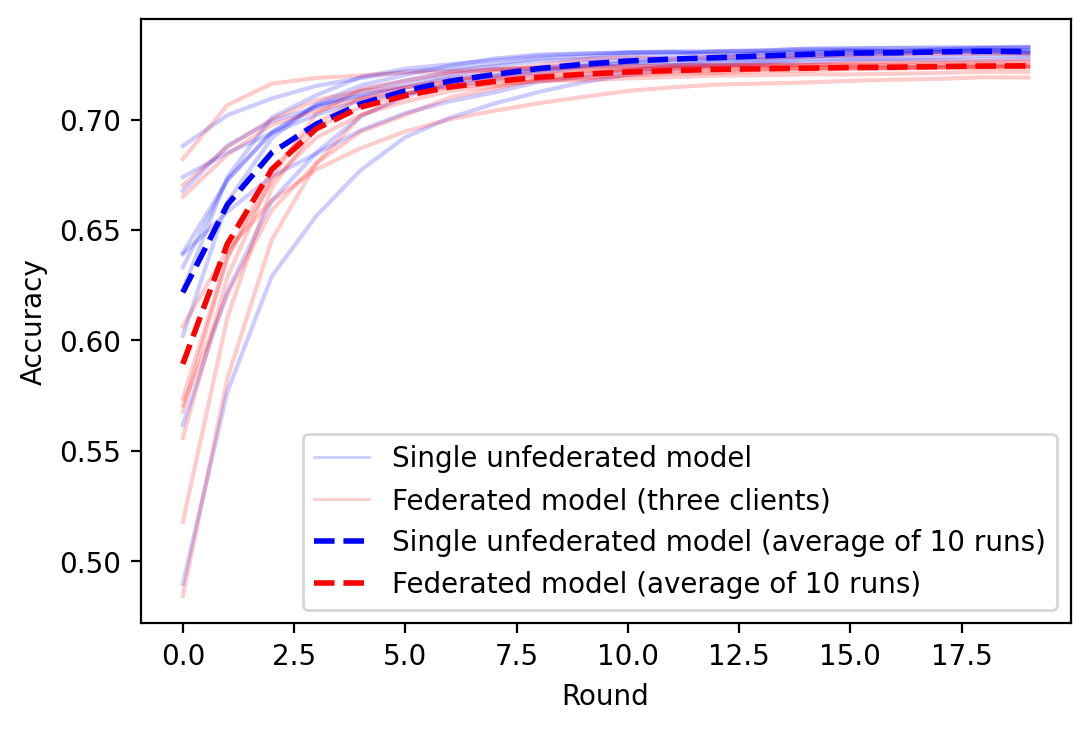

In [99]:
plt.subplots(dpi=200)

for j in range(10):
    plt.plot([results_unfed[j]['eval'][i]['eval']['binary_accuracy'] for i in range(len(results_unfed[j]['eval']))], c='b', alpha=0.2)
    
for j in range(10):
    plt.plot([results_fed[j]['eval'][i]['eval']['binary_accuracy'] for i in range(len(results_fed[j]['eval']))], c='r', alpha=0.2)

plt.plot(
    [np.mean([results_unfed[j]['eval'][i]['eval']['binary_accuracy'] for j in range(10)]) for i in range(len(results_unfed[0]['eval']))],
    lw=2,
    c='b',
    ls='--'
)
plt.plot(
    [np.mean([results_fed[j]['eval'][i]['eval']['binary_accuracy'] for j in range(10)]) for i in range(len(results_fed[0]['eval']))],
    lw=2,
    c='r',
    ls='--'
)
    
plt.xlabel("Round")
plt.ylabel("Accuracy")

from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], lw=1, c='b', alpha=0.2),
    Line2D([0], [0], lw=1, c='r', alpha=0.2),
    Line2D([0], [0], lw=2, c='b', ls='--'),
    Line2D([0], [0], lw=2, c='r', ls='--'),
               ]

#lines = ax.plot(data)
plt.legend(
    custom_lines, 
    ['Single unfederated model', 'Federated model (three clients)', 'Single unfederated model (average of 10 runs)', 'Federated model (average of 10 runs)',]
)

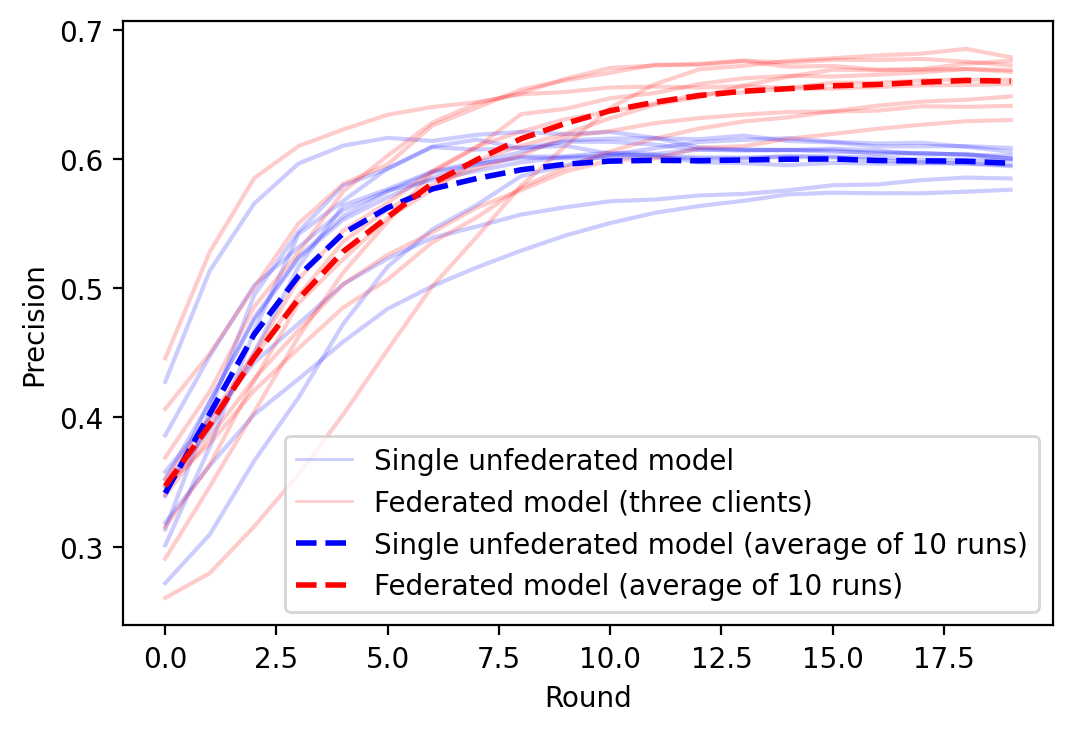

In [100]:
plt.subplots(dpi=200)

for j in range(10):
    plt.plot([results_unfed[j]['eval'][i]['eval']['Precision'] for i in range(len(results_unfed[j]['eval']))], c='b', alpha=0.2)
    
for j in range(10):
    plt.plot([results_fed[j]['eval'][i]['eval']['Precision'] for i in range(len(results_fed[j]['eval']))], c='r', alpha=0.2)

plt.plot(
    [np.mean([results_unfed[j]['eval'][i]['eval']['Precision'] for j in range(10)]) for i in range(len(results_unfed[0]['eval']))],
    lw=2,
    c='b',
    ls='--'
)
plt.plot(
    [np.mean([results_fed[j]['eval'][i]['eval']['Precision'] for j in range(10)]) for i in range(len(results_fed[0]['eval']))],
    lw=2,
    c='r',
    ls='--'
)
    
plt.xlabel("Round")
plt.ylabel("Precision")

from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], lw=1, c='b', alpha=0.2),
    Line2D([0], [0], lw=1, c='r', alpha=0.2),
    Line2D([0], [0], lw=2, c='b', ls='--'),
    Line2D([0], [0], lw=2, c='r', ls='--'),
               ]

#lines = ax.plot(data)
plt.legend(
    custom_lines, 
    ['Single unfederated model', 'Federated model (three clients)', 'Single unfederated model (average of 10 runs)', 'Federated model (average of 10 runs)',]
)

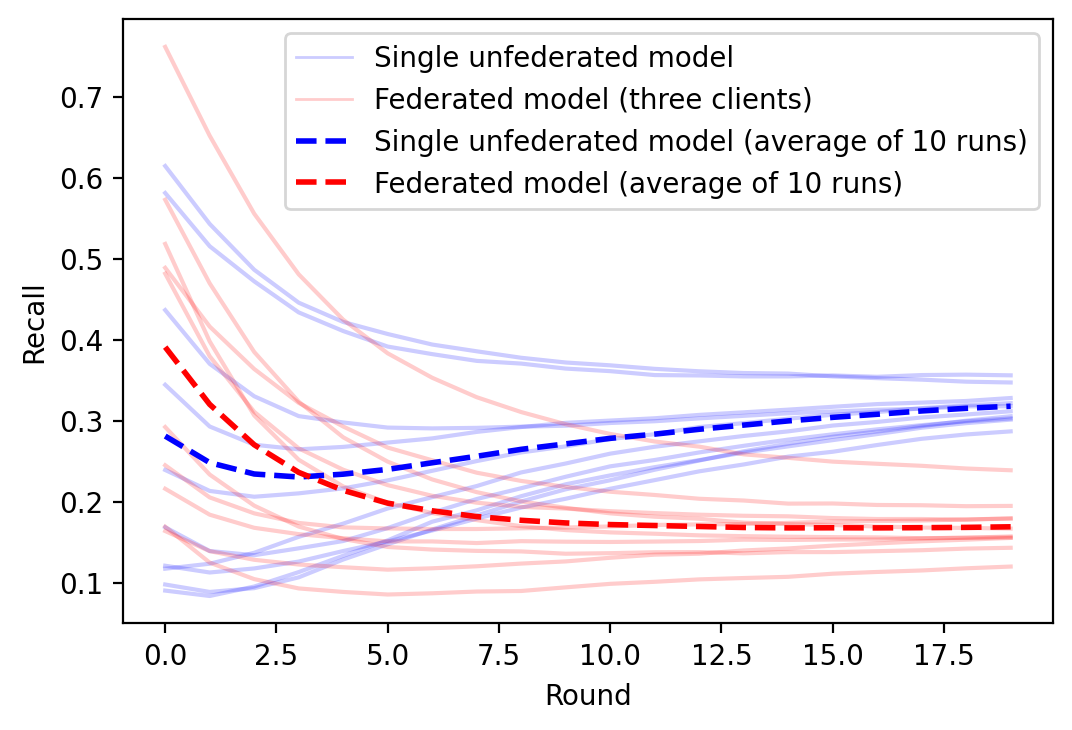

In [101]:
plt.subplots(dpi=200)

for j in range(10):
    plt.plot([results_unfed[j]['eval'][i]['eval']['Recall'] for i in range(len(results_unfed[j]['eval']))], c='b', alpha=0.2)
    
for j in range(10):
    plt.plot([results_fed[j]['eval'][i]['eval']['Recall'] for i in range(len(results_fed[j]['eval']))], c='r', alpha=0.2)

plt.plot(
    [np.mean([results_unfed[j]['eval'][i]['eval']['Recall'] for j in range(10)]) for i in range(len(results_unfed[0]['eval']))],
    lw=2,
    c='b',
    ls='--'
)
plt.plot(
    [np.mean([results_fed[j]['eval'][i]['eval']['Recall'] for j in range(10)]) for i in range(len(results_fed[0]['eval']))],
    lw=2,
    c='r',
    ls='--'
)
    
plt.xlabel("Round")
plt.ylabel("Recall")

from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], lw=1, c='b', alpha=0.2),
    Line2D([0], [0], lw=1, c='r', alpha=0.2),
    Line2D([0], [0], lw=2, c='b', ls='--'),
    Line2D([0], [0], lw=2, c='r', ls='--'),
               ]

#lines = ax.plot(data)
plt.legend(
    custom_lines, 
    ['Single unfederated model', 'Federated model (three clients)', 'Single unfederated model (average of 10 runs)', 'Federated model (average of 10 runs)',]
)

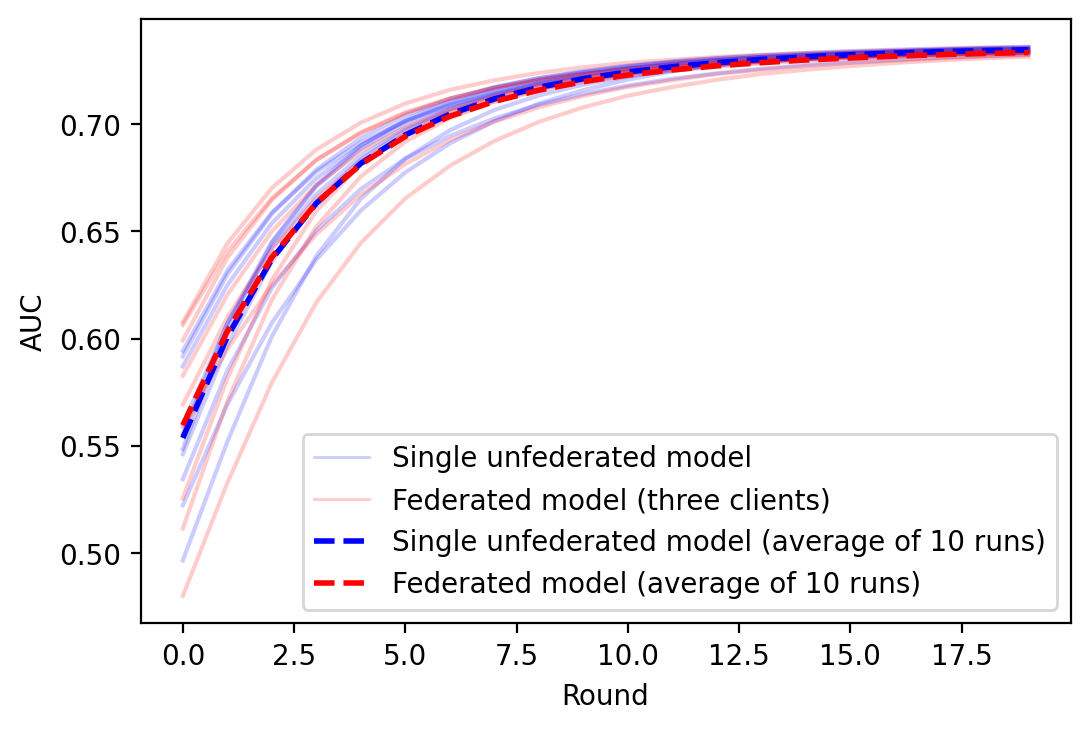

In [102]:
plt.subplots(dpi=200)

for j in range(10):
    plt.plot([results_unfed[j]['eval'][i]['eval']['AUC'] for i in range(len(results_unfed[j]['eval']))], c='b', alpha=0.2)
    
for j in range(10):
    plt.plot([results_fed[j]['eval'][i]['eval']['AUC'] for i in range(len(results_fed[j]['eval']))], c='r', alpha=0.2)

plt.plot(
    [np.mean([results_unfed[j]['eval'][i]['eval']['AUC'] for j in range(10)]) for i in range(len(results_unfed[0]['eval']))],
    lw=2,
    c='b',
    ls='--'
)
plt.plot(
    [np.mean([results_fed[j]['eval'][i]['eval']['AUC'] for j in range(10)]) for i in range(len(results_fed[0]['eval']))],
    lw=2,
    c='r',
    ls='--'
)
    
plt.xlabel("Round")
plt.ylabel("AUC")

from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], lw=1, c='b', alpha=0.2),
    Line2D([0], [0], lw=1, c='r', alpha=0.2),
    Line2D([0], [0], lw=2, c='b', ls='--'),
    Line2D([0], [0], lw=2, c='r', ls='--'),
               ]

#lines = ax.plot(data)
plt.legend(
    custom_lines, 
    ['Single unfederated model', 'Federated model (three clients)', 'Single unfederated model (average of 10 runs)', 'Federated model (average of 10 runs)',]
)

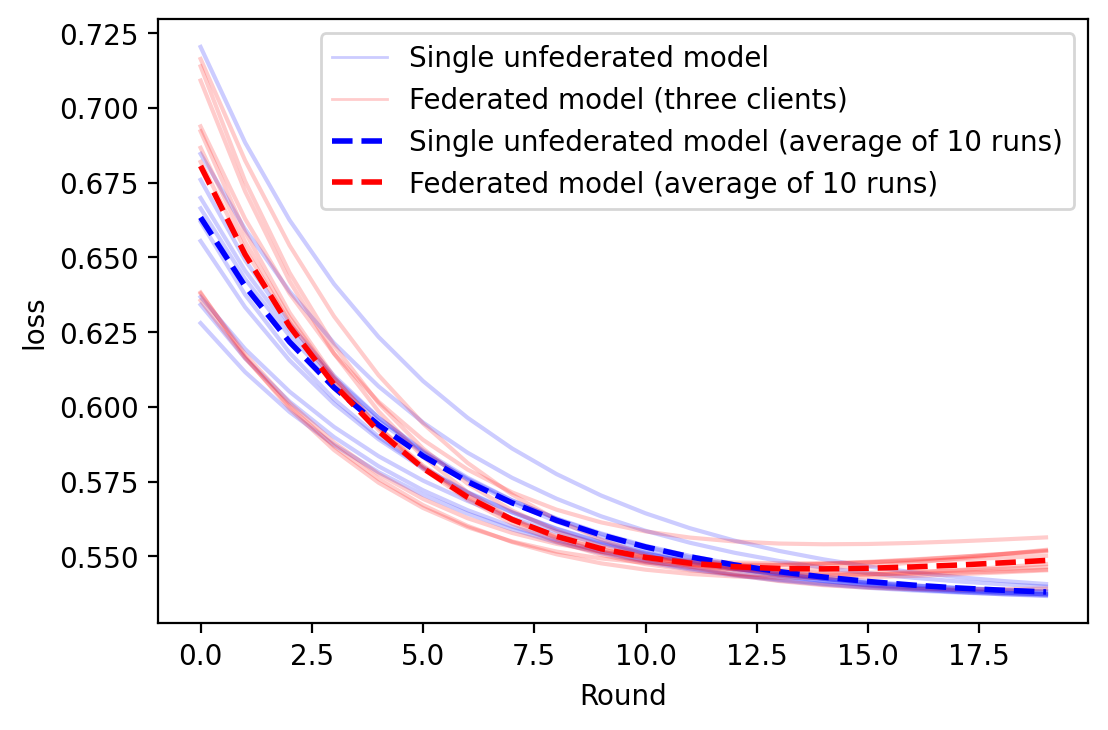

In [103]:
plt.subplots(dpi=200)

for j in range(10):
    plt.plot([results_unfed[j]['eval'][i]['eval']['loss'] for i in range(len(results_unfed[j]['eval']))], c='b', alpha=0.2)
    
for j in range(10):
    plt.plot([results_fed[j]['eval'][i]['eval']['loss'] for i in range(len(results_fed[j]['eval']))], c='r', alpha=0.2)

plt.plot(
    [np.mean([results_unfed[j]['eval'][i]['eval']['loss'] for j in range(10)]) for i in range(len(results_unfed[0]['eval']))],
    lw=2,
    c='b',
    ls='--'
)
plt.plot(
    [np.mean([results_fed[j]['eval'][i]['eval']['loss'] for j in range(10)]) for i in range(len(results_fed[0]['eval']))],
    lw=2,
    c='r',
    ls='--'
)
    
plt.xlabel("Round")
plt.ylabel("loss")

from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], lw=1, c='b', alpha=0.2),
    Line2D([0], [0], lw=1, c='r', alpha=0.2),
    Line2D([0], [0], lw=2, c='b', ls='--'),
    Line2D([0], [0], lw=2, c='r', ls='--'),
               ]

#lines = ax.plot(data)
plt.legend(
    custom_lines, 
    ['Single unfederated model', 'Federated model (three clients)', 'Single unfederated model (average of 10 runs)', 'Federated model (average of 10 runs)',]
)